In [2]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from scipy.signal import wavelets
from scipy import signal
import pywt
import numpy as np
import wandb
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computation Device: {DEVICE}")

# Set deterministic seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Computation Device: cuda


In [3]:
class MindscanDataset(Dataset):
    def __init__(self, subject_id, sets, n_classes=31, n_channels=16, seq_len=200):
        self.samples = []
        self.seq_len = seq_len
        emg_root = Path("/home/fisa/stockage1/mindscan/EMG")
        events_root = Path("/home/fisa/stockage1/mindscan/Events")
        
        subject = f"S{subject_id + 1:02d}"
        
        for set_num in sets:
            sequence = f"Sequence_{set_num:02d}"
            emg_file = emg_root / subject / sequence / "emg.csv"
            events_file = events_root / subject / sequence / "classif.csv"
            
            if emg_file.exists() and events_file.exists():
                df_emg = pd.read_csv(emg_file, sep=';').apply(lambda x: x.str.strip() if x.dtype == "object" else x)
                df_events = pd.read_csv(events_file, sep=';').apply(lambda x: x.str.strip() if x.dtype == "object" else x)
                
                for _, row in df_events.iterrows():
                    start, end, label = row['Timestamp Start'], row['Timestamp End'], int(row['Class'])
                    mask = (df_emg['EMG TIME'] >= start) & (df_emg['EMG TIME'] <= end)
                    
                    # Slicing indices 1:17 captures the 16 EMG channels, skipping 'EMG TIME'
                    signal_window = df_emg.loc[mask].iloc[:self.seq_len, 1:17].values
                    
                    if signal_window.shape[0] == self.seq_len and signal_window.shape[1] == 16:
                        # Store as (Channels, Time) tensor and 0-indexed label
                        self.samples.append((torch.tensor(signal_window.T).float(), label - 1))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        raw_signal, label = self.samples[idx]
        # On-the-fly CWT as recommended in the paper [cite: 110, 111]
        cwt_image = self.compute_cwt(raw_signal)
        return cwt_image, label
    
    def compute_cwt(self, signal_tensor):
        sig_np = signal_tensor.numpy()
        scales = np.arange(1, 65) # 64 frequency bins [cite: 117]
        cwt_out = []
        
        for ch in range(sig_np.shape[0]):
            # 'mexh' is the Ricker wavelet equivalent [cite: 117, 120]
            coeffs, _ = pywt.cwt(sig_np[ch], scales, 'mexh')
            cwt_out.append(coeffs)
        
        cwt_tensor = torch.tensor(np.array(cwt_out), dtype=torch.float32)
        
        # Bilinear interpolation for Vision Transformer input [cite: 123-130]
        cwt_resized = F.interpolate(
            cwt_tensor.unsqueeze(0), 
            size=(64, 64), 
            mode='bilinear', 
            align_corners=False
        ).squeeze(0)
        
        return cwt_resized

In [4]:
class AdaptiveConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AdaptiveConvBlock, self).__init__()
        # Parallel convolutions for multi-scale extraction [cite: 38, 142-144]
        self.branch1 = nn.Conv2d(in_channels, out_channels // 4, kernel_size=3, padding=1)
        self.branch2 = nn.Conv2d(in_channels, out_channels // 4, kernel_size=5, padding=2)
        self.branch3 = nn.Conv2d(in_channels, out_channels // 2, kernel_size=7, padding=3)
        
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2) # Downsample for hierarchical features [cite: 147]

    def forward(self, x):
        out = torch.cat([self.branch1(x), self.branch2(x), self.branch3(x)], dim=1)
        return self.pool(self.relu(self.bn(out)))

class SpectroViT(nn.Module):
    def __init__(self, num_classes=31, in_channels=16, embed_dim=256, depth=4, heads=8):
        super(SpectroViT, self).__init__()
        # Stage 1: Adaptive CNN Stem [cite: 157-163]
        self.stem = nn.Sequential(
            AdaptiveConvBlock(in_channels, 64),
            AdaptiveConvBlock(64, 128),
            AdaptiveConvBlock(128, embed_dim)
        )
        # Stage 2: Transformer Encoder [cite: 164-175]
        self.num_patches = 8 * 8
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=heads, dim_feedforward=embed_dim*4, 
            dropout=0.2, activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        # Stage 3: Head [cite: 176-183]
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2), nn.ReLU(),
            nn.Dropout(0.4), nn.Linear(embed_dim // 2, num_classes)
        )

    def forward(self, x):
        x = self.stem(x) # (B, 256, 8, 8)
        b, c, h, w = x.shape
        x = x.permute(0, 2, 3, 1).contiguous().view(b, h*w, c) # Flatten patches [cite: 189]
        x = self.transformer(x + self.pos_embedding)
        x = self.norm(x.mean(dim=1)) # Global Average Pooling [cite: 194]
        return self.head(x)

In [5]:
def get_mindscan_loaders(subject_id, batch_size=32):
    """
    Returns data loaders for a specific subject based on the Mindscan 
    10-set structure.
    """
    # Define the set splits as per the research protocol [cite: 134]
    train_sets = list(range(1, 9))  # Sets 1 to 8 [cite: 134]
    val_sets = list(range(9, 11))   # Sets 9 and 10 [cite: 134]
    
    # Initialize the datasets using the MindscanDataset class [cite: 135]
    train_ds = MindscanDataset(subject_id, train_sets)
    val_ds = MindscanDataset(subject_id, val_sets)
    
    # Create DataLoaders 
    # Training loader uses shuffle=True to improve generalization 
    train_loader = DataLoader(
        train_ds, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=2
    )
    
    # Validation loader uses shuffle=False for consistent evaluation 
    val_loader = DataLoader(
        val_ds, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=2
    )
    
    return train_loader, val_loader

In [ ]:
# Training & Evaluation Loop
def train_mindscan_subject(subject_id, config):
    # Grouping by "Mindscan_Benchmark" to organize the 24 subject runs
    run_name = f"Mindscan_Subj_{subject_id:02d}"
    run = wandb.init(
        project="Mindscan-SpectroViT",
        group="Mindscan_Subject_Sweep",
        name=run_name,
        config=config,
        reinit=True
    )
    
    train_loader, val_loader = get_mindscan_loaders(subject_id, config['batch_size'])
    
    model = SpectroViT(
        num_classes=31, 
        in_channels=16, 
        embed_dim=256, 
        depth=4, 
        heads=8
    ).to(DEVICE)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
    
    best_val_acc = 0.0
    
    for epoch in range(config['epochs']):
        # Train
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        train_acc = 100. * correct / total
        avg_train_loss = train_loss / len(train_loader)
        
        # Validate
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
        val_acc = 100. * correct / total
        avg_val_loss = val_loss / len(val_loader)
        
        wandb.log({
            "train_loss": avg_train_loss, "train_acc": train_acc,
            "val_loss": avg_val_loss, "val_acc": val_acc,
            "epoch": epoch
        })
        
        print(f"Subject {subject_id} | Ep {epoch+1} | Val Acc: {val_acc:.2f}%")
        
        # Save Best Model logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model_path = f"/home/fisa/stockage1/data_pirosa/models/best_model_subj_{subject_id}.pth"
            torch.save(model.state_dict(), model_path)
            # Log artifact to WandB
            artifact = wandb.Artifact(f'model-subj-{subject_id}', type='model')
            artifact.add_file(model_path)
            run.log_artifact(artifact)
            
        scheduler.step()
        
    run.finish()

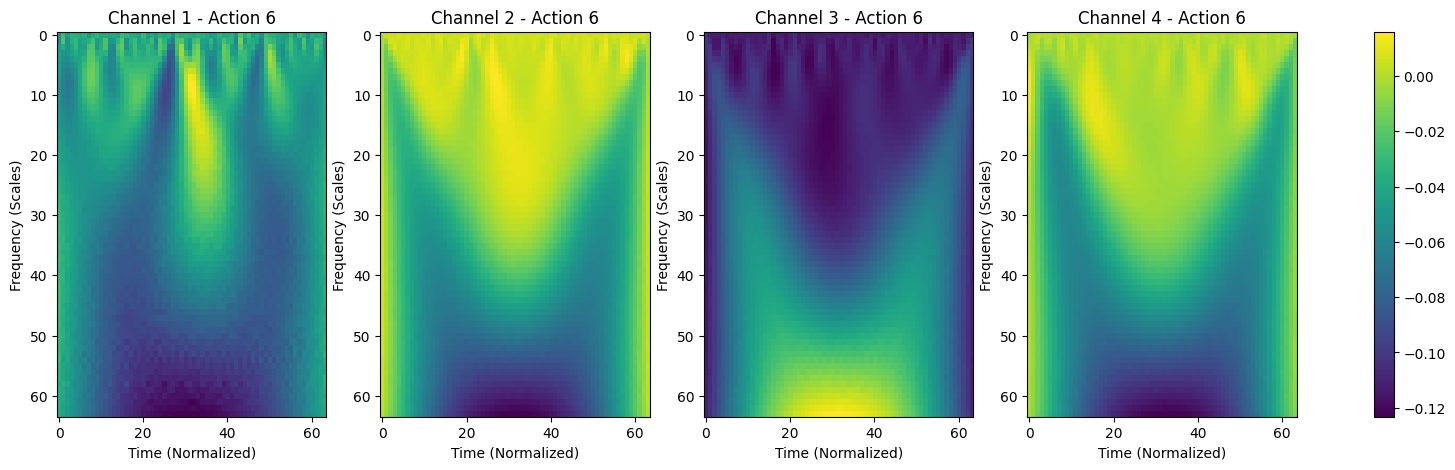

In [7]:
def visualize_subject_sti(subject_id, sample_idx=0):
    # Use the logic from our get_mindscan_loaders
    train_loader, _ = get_mindscan_loaders(subject_id, batch_size=1)
    cwt_images, labels = next(iter(train_loader))
    
    # cwt_images shape: (1, 16, 64, 64) -> (Batch, Channels, Freq, Time)
    # Let's visualize the first 4 channels
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for i in range(4):
        im = axes[i].imshow(cwt_images[0, i].cpu().numpy(), aspect='auto', cmap='viridis')
        axes[i].set_title(f"Channel {i+1} - Action {labels[0].item()+1}")
        axes[i].set_xlabel("Time (Normalized)")
        axes[i].set_ylabel("Frequency (Scales)")
    
    plt.colorbar(im, ax=axes.ravel().tolist())
    plt.show()

# Run this to verify the STI conversion
visualize_subject_sti(subject_id=0)

In [8]:
if __name__ == "__main__":
    # wandb.login(relogin=True,key="your_wandb_api_key_here")  # Replace with your actual API key
    config = {
        "dataset": "Mindscan",
        "epochs": 60,
        "batch_size": 32,
        "lr": 1e-4,
        "subjects": 24
    }
    
    print("Starting Mindscan 24-Subject Benchmark...")
    for subj in range(config['subjects']):
        print(f"\n--- Starting Subject {subj} ---")
        train_mindscan_subject(subj, config)

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /home/fisa/.netrc.


Starting Mindscan 24-Subject Benchmark...

--- Starting Subject 0 ---


wandb: Currently logged in as: aurelien-brouwers (aurelien-brouwers-imt-nord-europe) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Subject 0 | Ep 1 | Val Acc: 3.12%


RuntimeError: Parent directory /home/fisa/stockage1/data_pirosa does not exist.